In [153]:
# Import libraries
from openpyxl import load_workbook
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso,Ridge 
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Load datasets
wb2 = load_workbook('TrackingDataset.xlsx')

# Get Sheets
tracking_data = wb2['Tracking data']
point_locations = wb2['Point locations']

# Prepare Tracking Data DataFrame
data = DataFrame(tracking_data.values)
data = data.rename(columns={0:'ID', 1:'PI', 2:'WP', 3:'RSSI', 4:'FileTimeStamp', 5:'InsertionTimeStamp'})
data = data[1:]

# Prepare locations DataFrame
locations = DataFrame(point_locations.values)
locations = locations.rename(columns={0:'ID', 1:'X', 2:'Y'})
locations = locations[1:]

In [7]:
data = data[:150000]
data['WP_X'] = Series(0, index=data.index)
data['WP_Y'] = Series(0, index=data.index)
data['PI_X'] = Series(0, index=data.index)
data['PI_Y'] = Series(0, index=data.index)
data['Distance'] = Series(0, index=data.index)

def get_value(ID, cache, locations):
    if (ID in cache):
        return cache[ID]
    else:
        return locations.loc[locations['ID'] == ID]
    
WP_CACHE = {}
PI_CACHE = {}
i = 0
ROW_COUNT = data.shape[0]
for index, row in data.iterrows():
    WP_ID = 'wp' + str(row['WP'])
    PI_ID = 'pi' + str(row['PI'])
    
    wp_location = get_value(WP_ID, WP_CACHE, locations)
    pi_location = get_value(PI_ID, PI_CACHE, locations)
    
    if (not wp_location.empty and not pi_location.empty):
        data.at[index, 'WP_X'] = wp_location['X'].iloc[0]
        data.at[index, 'WP_Y'] = wp_location['Y'].iloc[0]
        data.at[index, 'PI_X'] = pi_location['X'].iloc[0]
        data.at[index, 'PI_Y'] = pi_location['Y'].iloc[0]
        data.at[index, 'Distance'] = math.sqrt(math.pow(wp_location['X'].iloc[0] - 
                                              pi_location['X'].iloc[0], 2) + math.pow(wp_location['Y'].iloc[0] 
                                                                                      - pi_location['Y'].iloc[0], 2))
    else:
        # Filter broken data
        data = data.drop(index)
        
    i += 1
    if (i % 1000 == 0):
        print('Done: ' + str(round(100 * i / ROW_COUNT, 2)) + '%')

Done: 0.67%
Done: 1.33%
Done: 2.0%
Done: 2.67%
Done: 3.33%
Done: 4.0%
Done: 4.67%
Done: 5.33%
Done: 6.0%
Done: 6.67%
Done: 7.33%
Done: 8.0%
Done: 8.67%
Done: 9.33%
Done: 10.0%
Done: 10.67%
Done: 11.33%
Done: 12.0%
Done: 12.67%
Done: 13.33%
Done: 14.0%
Done: 14.67%
Done: 15.33%
Done: 16.0%
Done: 16.67%
Done: 17.33%
Done: 18.0%
Done: 18.67%
Done: 19.33%
Done: 20.0%
Done: 20.67%
Done: 21.33%
Done: 22.0%
Done: 22.67%
Done: 23.33%
Done: 24.0%
Done: 24.67%
Done: 25.33%
Done: 26.0%
Done: 26.67%
Done: 27.33%
Done: 28.0%
Done: 28.67%
Done: 29.33%
Done: 30.0%
Done: 30.67%
Done: 31.33%
Done: 32.0%
Done: 32.67%
Done: 33.33%
Done: 34.0%
Done: 34.67%
Done: 35.33%
Done: 36.0%
Done: 36.67%
Done: 37.33%
Done: 38.0%
Done: 38.67%
Done: 39.33%
Done: 40.0%
Done: 40.67%
Done: 41.33%
Done: 42.0%
Done: 42.67%
Done: 43.33%
Done: 44.0%
Done: 44.67%
Done: 45.33%
Done: 46.0%
Done: 46.67%
Done: 47.33%
Done: 48.0%
Done: 48.67%
Done: 49.33%
Done: 50.0%
Done: 50.67%
Done: 51.33%
Done: 52.0%
Done: 52.67%
Done: 53.33%


In [8]:
# Write computed dataframe to file 
data.to_pickle('tracking_data.pkl')

In [3]:
# Read data from file
data = pd.read_pickle('tracking_data.pkl')

In [9]:
# Preview computed data
print(data.head())

       ID PI  WP RSSI         FileTimeStamp    InsertionTimeStamp  WP_X  WP_Y  \
1  913853  2  15  -84  2016-12-16 14:39:34Z  2016-12-16 14:41:36Z     0   176   
2  913854  2   8  -73  2016-12-16 14:39:34Z  2016-12-16 14:41:36Z     0    89   
3  913855  2  24  -75  2016-12-16 14:39:34Z  2016-12-16 14:41:36Z   293   263   
4  913857  2  13  -85  2016-12-16 14:39:34Z  2016-12-16 14:41:36Z   637    89   
5  913858  2   3  -89  2016-12-16 14:39:34Z  2016-12-16 14:41:36Z   148     0   

   PI_X  PI_Y  Distance  
1     0   323       147  
2     0   323       234  
3     0   323       299  
4     0   323       678  
5     0   323       355  


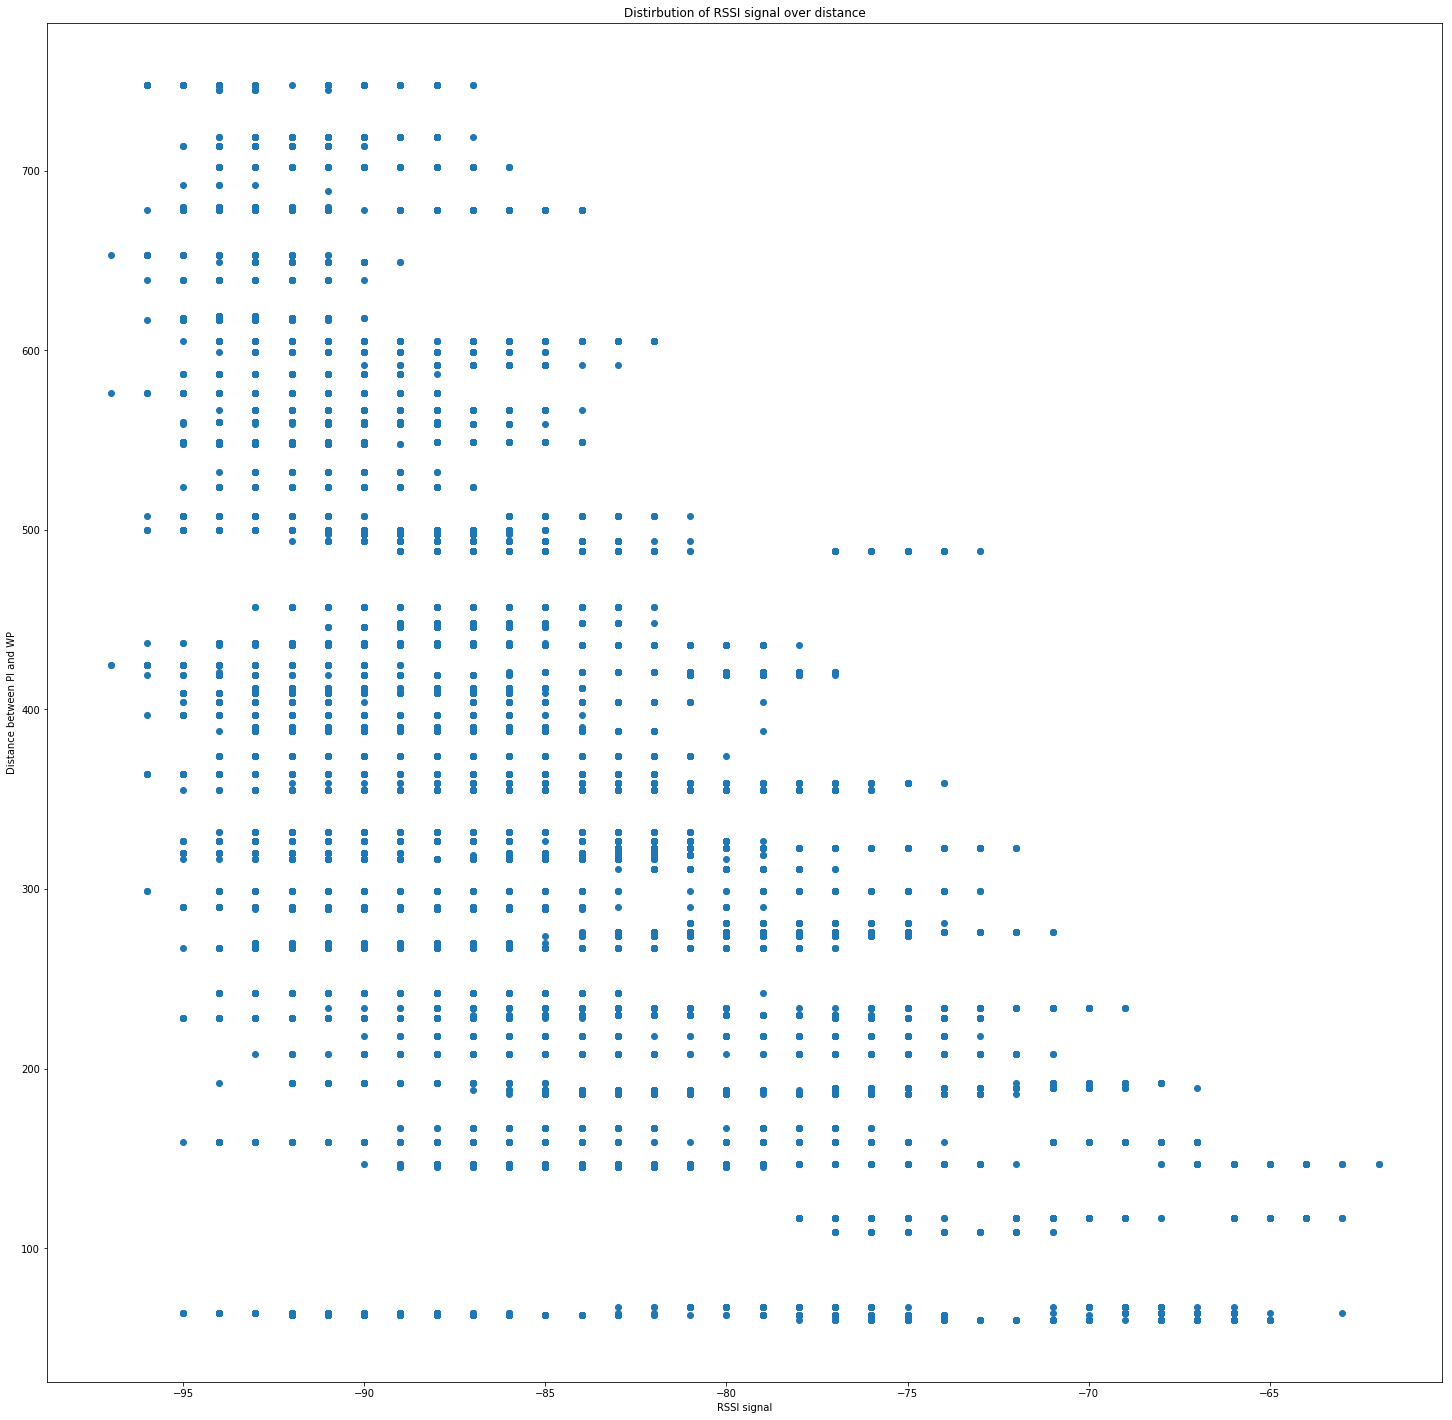

In [11]:
plt.figure(figsize=(25,25))
plt.scatter(data['RSSI'],data['Distance'])
plt.title('Distirbution of RSSI signal over distance')
plt.xlabel('RSSI signal')
plt.ylabel('Distance between PI and WP')
plt.show()

In [33]:
def plot_subplot_pi(pi, axarr, location1, location2):
    data_pi = data.loc[data['PI'] == pi]
    axarr[location1, location2].scatter(data_pi['RSSI'],data_pi['Distance'])
    axarr[location1, location2].set_title('Distirbution of RSSI signal over distance (PI' + str(pi) + ' only)')
    axarr[location1, location2].set_xlabel('RSSI signal')
    axarr[location1, location2].set_ylabel('Distance between PI and WP')

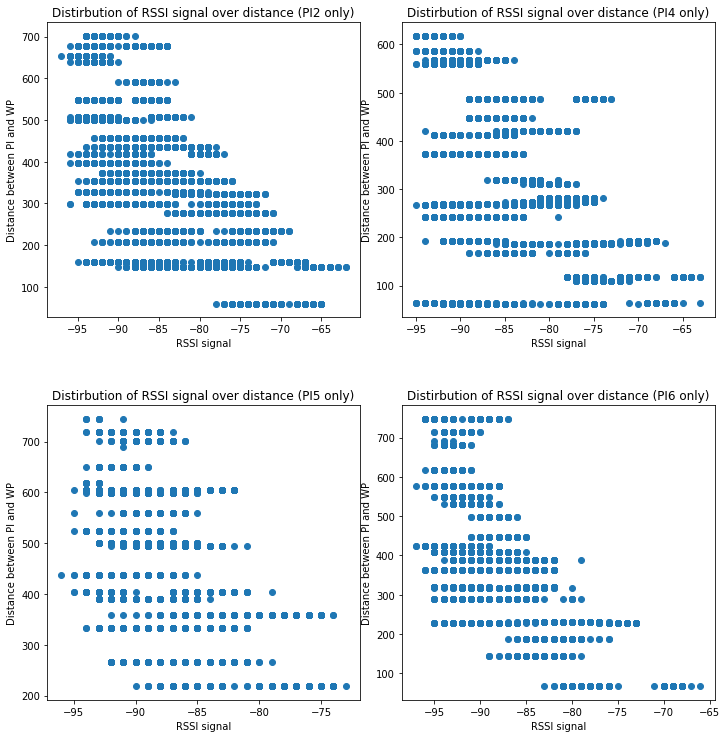

In [38]:
f, axarr = plt.subplots(2, 2, figsize=(10,10))
f.tight_layout()
f.subplots_adjust(hspace=0.3)
plot_subplot_pi(2, axarr, 0, 0)
plot_subplot_pi(4, axarr, 0, 1)
plot_subplot_pi(5, axarr, 1, 0)
plot_subplot_pi(6, axarr, 1, 1)
plt.show()

We can see sightly different distributions between a signal and RSSI signal for different PI devices.

In [40]:
def plot_subplot_wp(wp, axarr, location1, location2):
    data_pi = data.loc[data['WP'] == wp]
    axarr[location1, location2].scatter(data_pi['RSSI'],data_pi['Distance'])
    axarr[location1, location2].set_title('Distirbution of RSSI signal over distance (WP' + str(wp) + ' only)')
    axarr[location1, location2].set_xlabel('RSSI signal')
    axarr[location1, location2].set_ylabel('Distance between PI and WP')

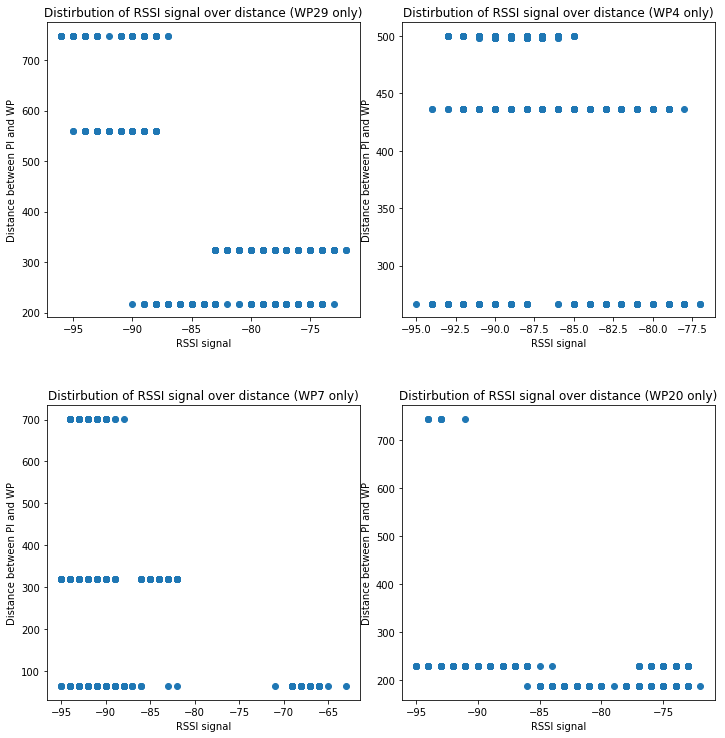

In [42]:
f, axarr = plt.subplots(2, 2, figsize=(10,10))
f.tight_layout()
f.subplots_adjust(hspace=0.3)
plot_subplot_wp(29, axarr, 0, 0)
plot_subplot_wp(4, axarr, 0, 1)
plot_subplot_wp(7, axarr, 1, 0)
plot_subplot_wp(20, axarr, 1, 1)
plt.show()

We can see here that for WP devices, some boundaries are tighter while others are wider

In [157]:
print ('Describe All PI(s) and WP(s)')
copyData = data[['RSSI','Distance']]
copyData['RSSI'] = copyData['RSSI'].apply(np.int64)
print(copyData.describe())

Describe All PI(s) and WP(s)
                RSSI       Distance
count  109538.000000  109538.000000
mean      -82.827713     324.206148
std         7.147223     162.548667
min       -97.000000      60.000000
25%       -89.000000     192.000000
50%       -84.000000     317.000000
75%       -77.000000     436.000000
max       -62.000000     748.000000


In [110]:
print ('Describe only PI2')
copyData = data.loc[data['PI'] == 2][['Distance', 'RSSI']]
copyData['RSSI'] = copyData['RSSI'].apply(np.int64)
print(copyData.describe())

Describe only PI2
           Distance          RSSI
count  36990.000000  36990.000000
mean     318.831955    -81.228008
std      157.405244      7.597222
min       60.000000    -97.000000
25%      208.000000    -88.000000
50%      323.000000    -82.000000
75%      419.000000    -75.000000
max      702.000000    -62.000000


In [116]:
print ('Describe only PI2 and WP28')
copyData = data.loc[(data['PI'] == 2) & (data['WP'] == 28)][['Distance', 'RSSI']]
copyData['RSSI'] = copyData['RSSI'].apply(np.int64)
print(copyData.describe())

Describe only PI2 and WP28
       Distance        RSSI
count     110.0  110.000000
mean      639.0  -92.890909
std         0.0    1.043507
min       639.0  -96.000000
25%       639.0  -94.000000
50%       639.0  -93.000000
75%       639.0  -92.000000
max       639.0  -90.000000


### Check regressions

In [68]:
def regressions(columns, data): 
    print('')
    msk = np.random.rand(len(data)) < 0.8
    X1 = data[columns]
    Y1 = data['Distance']
    train_X = X1[msk]
    train_Y = Y1[msk]
    test_X = X1[~msk]
    test_Y = Y1[~msk]

    names = ['LinearRegression', 'Ridge', 'Lasso']

    clf_list = [LinearRegression(),
                Ridge(),
                Lasso()]

    for name, clf in zip(names, clf_list):
        print(name, end=': ')
        clf.fit(train_X, train_Y)
        print(clf.score(test_X, test_Y))
    print('')
        
print ('Only RSSI -> Distance prediction: ')
regressions(['RSSI'], data)

print ('RSSI, PI, WP -> Distance prediction: ')
regressions(['PI','WP','RSSI'], data)

Only RSSI -> Distance prediction: 

LinearRegression: 0.43299969486871637
Ridge: 0.43299969206412214
Lasso: 0.43298234034854743

RSSI, PI, WP -> Distance prediction: 

LinearRegression: 0.44050855040199677
Ridge: 0.4405085495876063
Lasso: 0.4404750032645347



In [61]:
clf = SVR()

clf1 = SVR(C=1, cache_size=500, coef0=0.1, degree=5, epsilon=0.5, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
clf1.fit(train_X, train_Y)

print('Tuned Support Vector Regressor:')
print(clf1.score(test_X, test_Y))

Tuned Support Vector Regressor:
0.8794272848788559


Support Vector regressor seems to be much better that the regressions having PI ID, WP ID, RSSI as an input

In [62]:
mlp = MLPRegressor(alpha=41,hidden_layer_sizes=(1000,1000,1000))
mlp.fit(train_X,train_Y)

print('Tuned Neural Network:')
print(mlp.score(test_X, test_Y))

/Users/ekaterinafajzulova/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Tuned Neural Network:
0.9659489741730817


Neural network seems to return great results having PI ID, WP ID, RSSI as an input

In [165]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def func(x, a, b, c, d, e):
    return a * np.log10(b) + c * np.log10(d * np.abs(x)) + e

def func1(x, a, b):
    return a * np.log10(np.abs(x)) + b

def func2(x, a, b):
    return a * np.abs(x) + b

def func3(x, a, b, c):
    return a * np.abs(x) + b * x * x + c

def func4(x, a, b, c):
    return a * np.log(np.abs(x)) + b

def calculate_R2(funcs, optimized, test_X, test_Y):
    pred_Y = []
    for val in test_X['RSSI']:
        params = np.insert(optimized, 0, val)
        pred_Y.append(funcs(*params))
        
    return r2_score(test_Y, pred_Y)

### Fit functions

In [166]:
popt, pcov = curve_fit(func, train_X['RSSI'].apply(np.int64), train_Y)
print('Function a * log10(b) + c * np.log10(d * abs(x)) + e, R^2: ' + str(calculate_R2(func, popt, test_X, test_Y)))

popt, pcov = curve_fit(func1, train_X['RSSI'].apply(np.int64), train_Y)
print('Function a * log10(abs(x)) + b, R^2: ' + str(calculate_R2(func1, popt, test_X, test_Y)))

popt, pcov = curve_fit(func2, train_X['RSSI'].apply(np.int64), train_Y)
print('Function a * abs(x) + b, R^2: ' + str(calculate_R2(func2, popt, test_X, test_Y)))

popt, pcov = curve_fit(func3, train_X['RSSI'].apply(np.int64), train_Y)
print('Function a * abs(x) + b*x^2 + c, R^2: ' + str(calculate_R2(func3, popt, test_X, test_Y)))

popt, pcov = curve_fit(func4, train_X['RSSI'].apply(np.int64), train_Y)
print('Function a * log(np.abs(x)) + b, R^2: ' + str(calculate_R2(func4, popt, test_X, test_Y)))

Function a * log10(b) + c * np.log10(d * abs(x)) + e, R^2: 0.4233721112565879
Function a * log10(abs(x)) + b, R^2: 0.4233721233282103
Function a * abs(x) + b, R^2: 0.42697298064358846
Function a * abs(x) + b*x^2 + c, R^2: 0.4286731596961123
Function a * log(np.abs(x)) + b, R^2: 0.4233721234637907


The results are similar to a regression techniques

### Fit functions only for PI = 2 

In [167]:
X1 = data.loc[data['PI'] == 2][['PI','WP','RSSI']]
Y1 = data.loc[data['PI'] == 2]['Distance']
msk = np.random.rand(len(X1)) < 0.8
train_PI2_X = X1[msk]
train_PI2_Y = Y1[msk]
test_PI2_X = X1[~msk]
test_PI2_Y = Y1[~msk]

popt, pcov = curve_fit(func, train_PI2_X['RSSI'].apply(np.int64), train_PI2_Y)
print('Function a * log10(b) + c * np.log10(d * abs(x)) + e, R^2: ' + str(calculate_R2(func, popt, test_PI2_X, test_PI2_Y)))

popt, pcov = curve_fit(func1, train_PI2_X['RSSI'].apply(np.int64), train_PI2_Y)
print('Function a * log10(abs(x)) + b, R^2: ' + str(calculate_R2(func1, popt, test_PI2_X, test_PI2_Y)))

popt, pcov = curve_fit(func2, train_PI2_X['RSSI'].apply(np.int64), train_PI2_Y)
print('Function a * abs(x) + b, R^2: ' + str(calculate_R2(func2, popt, test_PI2_X, test_PI2_Y)))

popt, pcov = curve_fit(func3, train_PI2_X['RSSI'].apply(np.int64), train_PI2_Y)
print('Function a * abs(x) + b*x^2 + c, R^2: ' + str(calculate_R2(func3, popt, test_PI2_X, test_PI2_Y)))

popt, pcov = curve_fit(func4, train_PI2_X['RSSI'].apply(np.int64), train_PI2_Y)
print('Function a * log(np.abs(x)) + b, R^2: ' + str(calculate_R2(func4, popt, test_PI2_X, test_PI2_Y)))

Function a * log10(b) + c * np.log10(d * abs(x)) + e, R^2: 0.4796741603642012
Function a * log10(abs(x)) + b, R^2: 0.4796742342454511
Function a * abs(x) + b, R^2: 0.48074005877814574
Function a * abs(x) + b*x^2 + c, R^2: 0.4807420239011527
Function a * log(np.abs(x)) + b, R^2: 0.47967423397189146


When we fit results for a specific PI we get a better accuracy, all formulas doesn't seem to have a huge difference.